In [1]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import itertools
import sys
from sklearn.preprocessing import MinMaxScaler
import statistics
from IPython.display import clear_output
import time
import pickle
from scipy import spatial
from scipy.signal import find_peaks, peak_prominences

In [3]:
top_n=10 #top subsets to recalculate weights for
top_s=10
factor=10 #bass precision factor
N=60 # months to smooth

In [4]:
#open weighted features
cost_frame={}
with open('weighted_features_10t.pickle', 'rb') as handle:
    cost_frame = pickle.load(handle)

In [6]:
#load igor clusters file
clustered_techs_dict={}
with open('clustered_techs_dict.pickle', 'rb') as handle:
    clustered_techs_dict = pickle.load(handle)

In [7]:
#create a reverse dict, for each tech list possible anchors
techs_dict={}
for key,val in clustered_techs_dict.items():
    for tech in val:
        if tech not in techs_dict:
            techs_dict[tech]={}
        for anchor in key[0]:
            if anchor not in techs_dict[tech]:
                techs_dict[tech][anchor]=0
            techs_dict[tech][anchor]=techs_dict[tech][anchor]+key[1]
        techs_dict[tech]=techs_dict[tech]

In [8]:
filepath="./features/"
scaler = MinMaxScaler()

In [9]:
tech_list=list(techs_dict.keys())

anchors=['Lithium ion battery',
 'Cryptocurrency',
 '5g',
 'Open source model',
 'Facial recognition',
 'Cloud computing',
 'Streaming television',
 'e-Reader',
 'Capsule endoscopy',
 'Quadcopter',
 'Electronic cigarette',
 'Miniaturized satellite',
 'Electric vehicle']
anchors = [x.lower() for x in anchors]

In [10]:
for item in ['streaming television', 'miniaturized satellite']:
    anchors.remove(item)

In [11]:
#features smoothing loops
#for each remporal feature set the X axis as montly date from 1.1.10 to 1.11.21

f_lst={}
idx = pd.date_range('01-01-2010', '11-1-2021', freq='M')+ pd.DateOffset(1)
files = Path(filepath).rglob("*.csv")
for file in list(files)[:]:
    df=pd.read_csv(file,index_col=0,header=0).T
    df.iloc[:,:]=scaler.fit_transform(df.iloc[:,:])
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)
    df=df.T
    df.index=df.index.str.lower()
    anc_len=len(list(set(anchors)-set(list(df.index))))
    if anc_len<1:
        print(file.name[:-4],df.shape)
        f_lst[file.name[:-4]]=df.copy()
    else:
        pass
#         print("csv error:",anc_len,file.name[:-4],df.shape,)


files = Path(filepath).rglob("*.xlsx")    
for file in list(files)[:]:
    
    df=pd.read_excel(file,index_col=0).T
    
    df.iloc[:,:]=scaler.fit_transform(df.iloc[:,:])
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)
    df=df.T
    df.index=df.index.str.lower()
    anc_len=len(list(set(anchors)-set(list(df.index))))
    if anc_len<1:
        print(file.name[:-4],df.shape)
        f_lst[file.name[:-4]]=df.copy()
    else:
        print("excel error:",anc_len,file.name[:-4],df.shape,)


wiki_edits_monthly_count (419, 142)
wiki_edits_monthly_max_size (419, 142)
news_R&D (226, 142)
scientific_emergence (185, 142)
news_China (231, 142)
news_India (204, 142)
news_Israel (110, 142)
All_14112021210257. (430, 142)
Business & Industrial_14112021210433. (428, 142)
Finance_14112021210413. (411, 142)
Law & Government_14112021210335. (422, 142)
News_14112021210354. (415, 142)
No_publications_26102021212111. (440, 142)
Science_14112021210316. (428, 142)
wiki_views. (351, 142)
word_freq_techs_table. (430, 142)


In [12]:
def plot_bass(sales,t,name,plot=True,overfit=False,graph=False):
    c_sales=np.cumsum(sales)
    # initial variables(M, P & Q)
    m=sales.sum()
    vars = [0.003,0.038,m]

    # residual (error) function
    
    def residual(vars,m, t, sales):
        
        M=m
        if overfit:
            M = vars[2]
        P = vars[0]
        Q = vars[1]
        Bass = M * (((P+Q)**2/P)*np.exp(-(P+Q)*t))/(1+(Q/P)*np.exp(-(P+Q)*t))**2 
        return (Bass - (sales))

    # non linear least square fitting
    #varfinal,success
    if overfit:
        res= least_squares(residual, vars,
#                            bounds=([0.001, 0.01,0], [0.01,0.1,np.inf]), 
                           args=(m,t, sales))
    else:
        res= least_squares(residual, vars,
                           bounds=([0.001, 0.01,0], [0.01,0.1,np.inf]), 
                           args=(m,t, sales))
    

    # estimated coefficients
    
    p = res.x[0]
    q = res.x[1]
    
    m=m
    if overfit:
        m = res.x[2]
    
    if plot:
        print(residual([p,q,m],m, t, sales).mean())
        print(f"m:{m} \np:{p} \nq:{q} \n")
    
#     print(res)
#     sys.exit()
    
    
    #sales plot (pdf)
    #time interpolation
    tp=(np.linspace(1.0, sales.shape[0]*factor, num=sales.shape[0]*factor))/factor
    cofactor= np.exp(-(p+q) * tp)
    sales_pdf= m* (((p+q)**2/p)*cofactor)/(1+(q/p)*cofactor)**2
    sales_cdf= m*(1-cofactor)/(1+(q/p)*cofactor)
    if plot:
        plt.subplot(1, 2, 1)
        
        plt.plot(tp, sales_pdf,t,sales)
        plt.title(f'{name} pdf')
        plt.legend(['Fit', 'True'])


        # Cumulative sales (cdf)
        plt.subplot(1, 2, 2)
        
        plt.plot(tp, sales_cdf,t,c_sales)
        plt.title('Sales cdf')
        plt.legend(['Fit', 'True'])

        plt.show()
    if graph:
        return sales_pdf,res.x,res.cost
    else:
        return res.cost

In [ ]:
def get_best_anchor_bass(anchors_list,weight,subset):
    errors=[]
    # subsets=
    cost_weighted_list=[]
    #     try:
    
    cost=[]
    of_cost=[]
    final_bass=0
    pqm=[]
    err=100
    for name in anchors_list:
        sales=[]
        j=0
        for w,s in zip(weight,subset):
            df=f_lst[s]
            if (df.loc[df.index.str.lower()==name.lower(),:].shape[0]>0):
                sales.append(df.loc[df.index.str.lower()==name.lower(),:].values[0]*w)
            j+=1
    #             sales.append(df.loc[df.index.str.lower()==name.lower(),:].values[0])
        sales=np.add.reduce(sales)
        if sales.sum()>0:
            sales=np.trim_zeros(sales, 'f').astype(float)
            sales=np.convolve(sales, np.ones(N)/N, mode='valid')
            t= np.linspace(1.0, sales.shape[0], num=sales.shape[0])
            temp_final_bass,temp_pqm,temp_err=plot_bass(sales,t,name,plot=False,graph=True)
            peaks, _ = find_peaks(temp_final_bass, height=0)
            if peaks:
                if temp_err<err:
                    final_bass=temp_final_bass
                    err=temp_err

        else:
            errors.append(f"subset:{subset} name:{name}")
    g_anchor_bass=scaler.fit_transform(final_bass.reshape(-1, 1))
    g_anchor_bass=(g_anchor_bass-g_anchor_bass[1][0])/(1-g_anchor_bass[1][0])
    return g_anchor_bass

In [15]:

def fit_tech_to_bass(g_anchor_bass,g_tech,plot=False,method="lstsqr",start=0.3):
    fit_x=0
    fit_y=0
    diff=0.05
#     steps=np.arange(0.1,1+diff,diff)
    sim=1
    aa=0

#     for i in tqdm(range(12,len(g_anchor_bass)-len(g_tech))):
    while 1:        
        for i in range(1,len(g_anchor_bass)-len(g_tech)):
            steps=np.arange(start,1+diff,diff)
            for step in steps:
                a=g_tech.copy()
                a=np.interp(np.arange(0, len(a), len(a)/(len(a)+i)), np.arange(0, len(a)), a)
                
                a=a*step
                if method=="Cosine":
                    result = spatial.distance.cosine(a ,g_anchor_bass[:len(a),0])
                elif method=="lstsqr":
                    result = np.mean(np.square(a - g_anchor_bass[:len(a),0]))
                if sim>result:
                    fit_x=i
                    fit_y=step
                    sim=result
    #                 print(sim)
                    aa=a.copy()
        if fit_y>(start+diff*2):
            break
        else:
            start=start+diff
        if start>1:
            break 
        
    res=1 - spatial.distance.cosine(a , g_anchor_bass[:len(a)])
#     plt.plot(g_anchor_bass)
#     plt.plot(aa)
#     plt.show()

    
    return res,aa,fit_x,fit_y

In [16]:

def Diffusion_tech_fit(tech_name,length=1,plot=False):
#     print(tech_name)
    
    anchors_list=list(techs_dict[tech_name].keys())

#     print(anchors_list)

    df_w_metric=cost_frame.copy()
    while (1):
        df_w_metric=df_w_metric[df_w_metric["anchor_list"].astype(str)==str(anchors_list)]
#         print(df_w_metric.shape)
        if df_w_metric.shape[0]>0:
            break
        else:
            anchors_list=anchors_list[:-1]
        if len(anchors_list)==0:
            sys.exit()
            
# #     display(df_w_metric)
#     subset_dict={}
#     for subsets in df_w_metric["subset"]:
#         temp_sum=0
# #         print(subsets)
#         for subset in subsets:
#             df_test=f_lst[subset].copy()
#             if df_test[df_test.index==tech_name].shape[0]>0:
#                 temp_sum+=1
#         if temp_sum==len(subset):
#             print(subset)
#             sys.exit()
                
                
            
#             break
#         temp_sum
   
    threshold=0.5
    g_tech=0

    if threshold<min(df_w_metric["ratio"].values):
        min_threshold_reached=True
    conds=(df_w_metric["ratio"]>threshold) & (df_w_metric["length"]>length)
    while df_w_metric[conds].shape[0]==0:
        threshold*=0.9
        conds=(df_w_metric["ratio"]>threshold) & (df_w_metric["length"]>length)

    df_w_metric[conds].reset_index()

    ii=0

    subset=0
    for row in df_w_metric.iterrows():
        subset=row[1]["subset"]
        weight=row[1]["weights"]
        
        g_tech=get_tech_graph(tech_name,weight,subset)
        ii+=1
        if not isinstance(g_tech,int):
            if g_tech.shape[0]>0:
                break
    ii=0
    if isinstance(g_tech,int):
        for row in df_w_metric.iterrows():
            subset=row[1]["subset"]
            weight=row[1]["weights"]
            g_tech=get_tech_graph(tech_name,weight,subset,diff_test=False)
            ii+=1
            if not isinstance(g_tech,int):
                if g_tech.shape[0]>0:
                    break

    ##find minima
#     print(g_tech)
    g_tech=g_tech[:,0]*-1
    peaks, properties = find_peaks(g_tech, prominence=(0.2,20))
    ##find maxima
    g_tech=g_tech*-1
    peaks_max, properties = find_peaks(g_tech, prominence=(0.2,20))
    
    
    
   



    if plot:
        plt.subplot(2, 2, 1)
        plt.plot(g_tech)
        plt.plot(peaks, g_tech[peaks], "x")
        plt.plot(peaks_max, g_tech[peaks_max], "o")
#         axs[0].show()
    slice_point=peaks[g_tech[peaks]<0.1]
    if slice_point.shape[0]>0:
        slice_point=slice_point[-1]
        g_tech=g_tech[slice_point:]
        if plot:
            plt.subplot(2, 2, 2)
            plt.plot(g_tech[slice_point:])
#             axs[1].show()

#     print(g_tech)
    tech_len=g_tech.shape[0]
    g_anchor_bass=get_best_anchor_bass(anchors_list,weight,subset)
    peaks, _ = find_peaks(g_anchor_bass[:,0], height=0.5)
    
    peaks_max, properties = find_peaks(g_tech, prominence=(0.2,20))
    
    start=0.3
    method="lstsqr"
    if peaks_max.shape[0]>0:
        if max(g_tech[peaks_max])==max(g_tech):
            method="Cosine"
            start=0.7

    res,a,fit_x,fit_y=fit_tech_to_bass(g_anchor_bass,g_tech,plot=plot,method=method,start=start)
#     print(len(g_tech),peaks[0],fit_x+len(g_tech))
    diffusion_precent=(len(g_tech)+fit_x)/peaks[0]
    years=peaks[0]*diffusion_precent/12
#     a=g_tech.copy()*fit_y
#     a=np.interp(np.arange(0, len(a), len(a)/(len(a)+fit_x)), np.arange(0, len(a)), a)
    if plot:
        plt.subplot(2, 2, 3)
#         print(f"Tech: {tech_name} ,Diffusion:{diffusion_precent} Cosine similarity: {res}")
#         print(fit_x,fit_y)
        
        
        plt.plot(g_anchor_bass[g_anchor_bass>=0])
        plt.plot(a)
#         axs[2].show()
        plt.show()
    return {"name":tech_name,"subset":subset,"weights":weight,"years":years,
            "score":res,"diffusion":diffusion_precent,
            "fit x":fit_x,"fit y":fit_y,"tech_len":tech_len,
           "tech_graph":a,"tech_bass":g_anchor_bass,"peaks":peaks_max}

In [17]:
def get_tech_graph(tech_name,weight,subset,diff_test=True):
    g_tech=[]
    for w,s in zip(weight,subset):
            df=f_lst[s].copy()
            if df.loc[df.index.str.lower()==tech_name.lower(),:].values.shape[0]>0:
                g_tech.append(df.loc[df.index.str.lower()==tech_name.lower(),:].values[0]*w)
    
    g_tech=np.add.reduce(g_tech)
#     print("$$$$$",np.diff(g_tech))
#     plt.plot(g_tech)
#     plt.show()
    if diff_test:
        if np.diff(g_tech).sum()==0:
            return 0
    
    if(g_tech-min(g_tech)).sum()==0:
        return 0
    g_tech=np.trim_zeros(g_tech, 'f').astype(float)
    g_tech=np.convolve(g_tech, np.ones(N)/N, mode='valid')
    t= np.linspace(1.0, g_tech.shape[0], num=g_tech.shape[0])
    
    g_tech=scaler.fit_transform(g_tech.reshape(-1, 1))
#     print("$$$$$",g_tech.shape)
    return g_tech

In [18]:
score_lst={}

In [19]:
errors=[]
for tech_name in tqdm(list(techs_dict.keys())):
    try:
        if tech_name not in score_lst:
            score_lst[tech_name]=Diffusion_tech_fit(tech_name)
    except Exception as e:
        errors.append(tech_name)
        print(tech_name)
        print(e)
        print("\n\n\n")


 12%|█████████▍                                                                       | 44/376 [01:10<07:36,  1.37s/it]

stem-cell therapy
'int' object is not subscriptable






 24%|███████████████████▌                                                             | 91/376 [02:22<07:24,  1.56s/it]

ai arbitration
diff requires input that is at least one dimensional




anti-degenerative medicine
diff requires input that is at least one dimensional






 25%|████████████████████▎                                                            | 94/376 [02:23<03:25,  1.37it/s]

deep trench capacitor
diff requires input that is at least one dimensional




dna-templated organic synthesis
diff requires input that is at least one dimensional






 26%|████████████████████▉                                                            | 97/376 [02:25<03:20,  1.39it/s]

haptic feedback systems
diff requires input that is at least one dimensional




holograms for solar
diff requires input that is at least one dimensional






 27%|█████████████████████▋                                                          | 102/376 [02:30<04:40,  1.03s/it]

nanocharging solar
diff requires input that is at least one dimensional






 28%|██████████████████████▏                                                         | 104/376 [02:31<03:50,  1.18it/s]

neuron control
diff requires input that is at least one dimensional




next gen web search
diff requires input that is at least one dimensional




photonic laser thruster
diff requires input that is at least one dimensional






 29%|███████████████████████▍                                                        | 110/376 [02:37<05:05,  1.15s/it]

ultradense molecular memory
diff requires input that is at least one dimensional






 30%|███████████████████████▊                                                        | 112/376 [02:39<04:55,  1.12s/it]

vortex ring gun
diff requires input that is at least one dimensional






 40%|████████████████████████████████▏                                               | 151/376 [03:38<04:04,  1.09s/it]

companion robot
'int' object is not subscriptable




extreme life extension

 40%|████████████████████████████████▎                                               | 152/376 [03:38<03:03,  1.22it/s]


'int' object is not subscriptable






 45%|███████████████████████████████████▉                                            | 169/376 [04:07<04:18,  1.25s/it]

delay-line oscillator
'int' object is not subscriptable






 53%|██████████████████████████████████████████▏                                     | 198/376 [04:53<03:53,  1.31s/it]

genome prime editing
'int' object is not subscriptable






 55%|███████████████████████████████████████████▊                                    | 206/376 [05:09<04:22,  1.55s/it]

structurally nanoengineered antimicrobial polypeptide polymers
'int' object is not subscriptable






 59%|███████████████████████████████████████████████                                 | 221/376 [05:28<03:43,  1.44s/it]

reusable rocket technology for orbital rockets
'int' object is not subscriptable






 83%|██████████████████████████████████████████████████████████████████▏             | 311/376 [08:10<01:28,  1.36s/it]

in-memory processing
'int' object is not subscriptable






 85%|████████████████████████████████████████████████████████████████████            | 320/376 [08:24<01:03,  1.14s/it]

wi-fi 6
'int' object is not subscriptable






 87%|█████████████████████████████████████████████████████████████████████▊          | 328/376 [08:39<01:07,  1.40s/it]

nanoradio
'int' object is not subscriptable






 90%|███████████████████████████████████████████████████████████████████████▉        | 338/376 [08:49<00:31,  1.20it/s]

supercritical water reactor
'int' object is not subscriptable






 94%|███████████████████████████████████████████████████████████████████████████▎    | 354/376 [09:10<00:29,  1.34s/it]

organic solar cell
'int' object is not subscriptable






 95%|███████████████████████████████████████████████████████████████████████████▉    | 357/376 [09:12<00:16,  1.16it/s]

generation iv reactor
'int' object is not subscriptable






 95%|████████████████████████████████████████████████████████████████████████████▏   | 358/376 [09:12<00:12,  1.43it/s]

liquid crystal elastomers
'int' object is not subscriptable






 99%|███████████████████████████████████████████████████████████████████████████████▎| 373/376 [09:34<00:04,  1.52s/it]

biobattery
'int' object is not subscriptable






 99%|███████████████████████████████████████████████████████████████████████████████▌| 374/376 [09:34<00:02,  1.16s/it]

cortical implant
'int' object is not subscriptable






100%|████████████████████████████████████████████████████████████████████████████████| 376/376 [09:37<00:00,  1.54s/it]


In [224]:
#save to pickle
with open('"C:\Users\nehor\Google Drive\Neura machine\tech_scraper\diffusion.pickle"', 'wb') as handle:
        pickle.dump(score_lst, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
def get_last_derrative(x):
    per_len=round(x.shape[0]*0.1)
    score=(x[-1]-x[-1*per_len])/per_len
    return score

def trim_negative(x):
    return x[x>0]

In [24]:
#clean unwanted techs with filters
dff=pd.DataFrame.from_records(score_lst).T

dff["tech_bass"]=dff.loc[dff["tech_bass"].notnull(),"tech_bass"].apply(trim_negative)
conds=(dff["diffusion"]<1 & (dff["diffusion"]>0))
dff.loc[conds,"years"]=(dff.loc[conds,"tech_len"]/dff.loc[conds,"diffusion"])/12-dff.loc[conds,"tech_len"]/12
conds=dff["diffusion"]>=1
dff.loc[conds,"years"]=(dff.loc[conds,"tech_len"]/dff.loc[conds,"diffusion"])/12-dff.loc[conds,"tech_len"]/12

<AxesSubplot:>

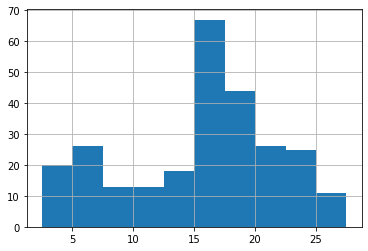

In [27]:
dff.loc[(dff["years"]<30) & (dff["years"]>0),"years"].hist()